In [1]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt


# Preparation

## Load the dataset

In [2]:
#the dataset can be loaded as a split of training and test dataset, images and labels
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


The shape of the image set:  (50000, 32, 32, 3)
The shape of the label set:  (50000, 1)
Print a label:  [9]


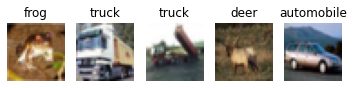

In [3]:
print("The shape of the image set: ", training_images.shape)
print("The shape of the label set: ", training_labels.shape)
print("Print a label: ", training_labels[1])
name_dict = {0: "airplane",1:"automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
fig, ax = plt.subplots(1,5)

for count in range(5):
  img = training_images[count]
  label = int(training_labels[count])
  ax[count].imshow(img)
  ax[count].set_title(name_dict[label])
  ax[count].axis("off")


## Input Pipeline
Preprocess the data for better handling

In [4]:
#create a TensorFlow Dataset object: images are separated along 1 dimension 
training_images = tf.data.Dataset.from_tensor_slices(training_images)

#normalize images
training_images = training_images.map(lambda img: tf.math.divide(img,255))

#if you want to check how the images look now, try:
#iterator = tf.compat.v1.data.make_one_shot_iterator(training_images)
#image = iterator.get_next()
#print(image)

#encode labels as one_hot vectors
training_labels = tf.data.Dataset.from_tensor_slices(training_labels.reshape((-1,)))
training_labels = training_labels.map(lambda x: tf.one_hot(x, 10))

#combine labels and images
train_dataset = tf.data.Dataset.zip((training_images, training_labels))


#finally prepare the dataset
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.shuffle(buffer_size = 64)
train_dataset = train_dataset.prefetch(buffer_size = 16)
print(train_dataset)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [5]:
#create a TensorFlow Dataset object: images are separated along 1 dimension 
test_images = tf.data.Dataset.from_tensor_slices(test_images)


#normalize images
test_images = test_images.map(lambda img: tf.math.divide(img,255))

#encode labels as one_hot vectors
test_labels = tf.data.Dataset.from_tensor_slices(test_labels.reshape((-1,)))

test_labels = test_labels.map(lambda x: tf.one_hot(x, 10))

#combine labels and images
test_dataset = tf.data.Dataset.zip((test_images, test_labels))

#finally prepare the dataset
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.shuffle(buffer_size = 64)
test_dataset = test_dataset.prefetch(buffer_size = 16)
print(test_dataset)

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>


# Model (CNN)

In [6]:
#So in preprocessing we already applied normalization on the input

#To make use of optimization techniques in our model
#1. we make sure to use a weight regularizer: l2 loss, to regulate weight updates and to not let them get too large
#2. make use of initialization: both of bias = 0 and the weights drawn from a gloriot_uniform (keep the weights centered around 0)
#3. use batch_normalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer


class Model(Model):
  def __init__(self):
    super(Model, self).__init__()

    #batch_normalization layer:
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()
    self.batch_norm_4 = tf.keras.layers.BatchNormalization()
    self.batch_norm_5 = tf.keras.layers.BatchNormalization()
    self.batch_norm_6 = tf.keras.layers.BatchNormalization()

    #as we want to apply activation_function after normalization we need an activation_function layer
    self.relu = tf.keras.activations.relu

    # Define the three convolutional layers with Pooling layers in between
    self.conv_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01),
                                    #already done implicitly: but to make it explicit we initialize the bias as 0 to keep the weights centered around 0
                                            bias_initializer = tf.keras.initializers.Constant(value=0), 
                                    #also already done implicitly: but to make it explicit we initialize the weights by drawing from a uniform distribution
                                    #that is centered around 0
                                         kernel_initializer = tf.keras.initializers.GlorotUniform,
                                          input_shape=(64,32,32,3) 
                                            )
    
    self.max_pool_1 = tf.keras.layers.MaxPool2D((2,2), )
    self.conv_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)
                                          #layer already knows input shape
                                        )
    
    self.max_pool_2 = tf.keras.layers.MaxPool2D()
    self.conv_3 = tf.keras.layers.Conv2D(filters = 128, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)
                                            )
    
    

    self.conv_4 = tf.keras.layers.Conv2D(filters = 256, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)
                                            )
    self.conv_5 = tf.keras.layers.Conv2D(filters = 128, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)
                                            )
    self.max_pool_3 = tf.keras.layers.MaxPool2D()
    self.conv_6 = tf.keras.layers.Conv2D(filters = 128, kernel_size= 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.01)
                                            )


    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

    #to perform dropout and there by prevent the danger of focussing too much on single weights we use a dropout layer
    self.dropout = tf.keras.layers.dropout(0.3)


    #classifier: simple MLP
    self.hidden_layer = tf.keras.layers.Dense(units=256,
                                            activation=tf.keras.activations.sigmoid )
    self.output_layer = tf.keras.layers.Dense(units=10,
                                            activation=tf.keras.activations.softmax #softmax: it gives us the probability for each of the 10 classes
                                            )
        

  def call(self, input, training):
    x = self.conv_1(input)
    x = self.batch_norm_1(x,training)
    x = self.relu(x)
    #x = self.dropout(x, training)
    

    x = self.conv_2(x)
    x = self.batch_norm_2(x,training)
    x = self.relu(x)
    #x = self.dropout(x, training)
    x = self.max_pool_1(x)

    x = self.conv_3(x)
    x = self.batch_norm_3(x,training)
    x = self.relu(x)
    #x = self.dropout(x, training)
    x = self.conv_4(x)
    x = self.batch_norm_4(x,training)
    x = self.relu(x)
    x = self.max_pool_2(x)

    x = self.conv_5(x)
    x = self.batch_norm_5(x,training)
    x = self.relu(x)
    x = self.max_pool_3(x)

    x = self.conv_6(x)
    x = self.batch_norm_6(x,training)
    x = self.relu(x)

    x = self.global_pool(x)
    x = self.hidden_layer(x)
    x = self.output_layer(x)

    return x


# Training

## Training step - do a forward pass

In [7]:
def train_step(model, input, target, loss_function, optimizer, training=True):

  with tf.GradientTape() as tape:
    prediction = model(input,training)

    #calculate the loss as a sum of the SGD to minimize prediction error and l2 regularization (penalize large weights)
    loss = loss_function(prediction,target) + tf.reduce_sum(model.losses)
    #calculate the accuracy by moving along the vector of targets (per input)
    # comparing the correct target value to the class with the highest prediction
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    #calculate the gradients for the weights with respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
  
  #update the weights
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

## Testing step

In [8]:
#testing a batch
def test(model, data, loss_function, training= False):
  test_losses = []
  test_accuracies = []

  #iterate over image, label tuples in the batch
  for (input,target) in data:
    #compute the prediction for the model (forward pass)
    prediction = model(input, training)
    #compute the loss of the model with the loss function 
    loss = loss_function(prediction,target)
    
    #compare the real to the predicted label 
    #the predicted label is the category with the highest probability
    accuracy = (np.argmax(prediction, axis=1) == np.argmax(target,axis=1))
  
    #add the computed values to the aggregation lists
    test_losses.append(loss.numpy())
    #before adding the accuracy we take it's mean to 
    test_accuracies.append(np.mean(accuracy))

  t_loss = np.mean(test_losses)
  t_accuracy = np.mean(test_accuracies)

  return t_loss, t_accuracy

## Start training

In [9]:
tf.keras.backend.clear_session()

#Initialize model
model = Model()

#hyperparameters
epochs = 30
learning_rate = 0.0001 

loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95

#To keep track of the processes, we use several lists
training_steps = []

train_losses= []
train_accuracies = []

test_losses = []
test_accuracies = []

#how does the model do on training data before training?
train_loss, train_accuracy = test(model, train_dataset, loss_function)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

#test once before training the model
test_loss, test_accuracy = test(model, test_dataset, loss_function, False)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#now start to train
#run through the training_data_set in one epoch and adapt parameters (batchwise)
#repeat for number of epochs

for epoch in range(epochs):
  print( "---------------------------------------- Epoch Number:", epoch)

  training_steps.append(epoch)

  train_dataset = train_dataset.shuffle(buffer_size=64)
  test_dataset = test_dataset.shuffle(buffer_size=64)

  running_average_loss = 0
  running_average_accuracy = 0

  #perform test
  for (input,target) in train_dataset:
    training_loss,training_accuracy = train_step(model, input, target, loss_function, optimizer, True)

    running_average_accuracy = running_average_factor * running_average_accuracy + (1-running_average_factor)*training_accuracy
    running_average_loss = running_average_factor * running_average_loss + (1-running_average_factor)*training_loss

  #After completing the batches we append the computed accuracy to our list
  train_accuracies.append(running_average_accuracy)
  train_losses.append(running_average_loss)

  #now evaluate the performance of the model
  test_loss, test_accuracy = test(model, test_dataset, loss_function, False)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  #print current performance data
  print('training_loss: ', running_average_loss.numpy(), 'training_accuracy: ', running_average_accuracy)
  print('test_loss: ', test_loss, 'test_accuracy: ', test_accuracy)



---------------------------------------- Epoch Number: 0
training_loss:  12.153374 training_accuracy:  0.44342847971461063
test_loss:  10.258474 test_accuracy:  0.3817675159235669
---------------------------------------- Epoch Number: 1
training_loss:  11.045095 training_accuracy:  0.4643710085559559
test_loss:  9.919157 test_accuracy:  0.39281449044585987
---------------------------------------- Epoch Number: 2
training_loss:  10.185125 training_accuracy:  0.500845833036004
test_loss:  9.316753 test_accuracy:  0.4267515923566879
---------------------------------------- Epoch Number: 3
training_loss:  9.669348 training_accuracy:  0.5417012196987196
test_loss:  8.597015 test_accuracy:  0.4903463375796178
---------------------------------------- Epoch Number: 4
training_loss:  8.661115 training_accuracy:  0.585113213584911
test_loss:  8.918312 test_accuracy:  0.4560111464968153
---------------------------------------- Epoch Number: 5
training_loss:  7.8573833 training_accuracy:  0.632607

# Visualisation

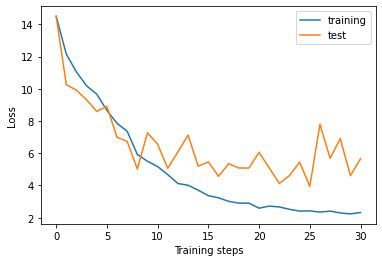

In [10]:
import matplotlib.pyplot as plt

#do the visualization
#test loss and training loss
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

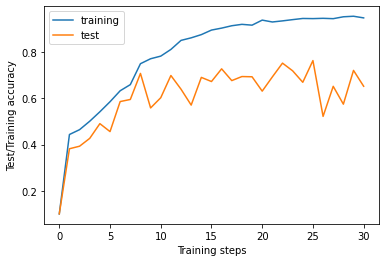

In [11]:
#test accuracy and training accuracy
plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Test/Training accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()